# MNIST Dataset with Convnet

In [1]:
# A bunch of imports, not very interesting
from __future__ import division, print_function, absolute_import

# utility packages
import random, os
import datetime as dt
import itertools as it

# TensorFlow is here
import tensorflow as tf
import tflearn

# For numerical computation
import numpy as np
import pandas as pd

# For plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
% matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10)

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


Here I'll be loading a saved Convolutional Network - this is the best model I've been able to run so far. First we have to load the data, and the network model.

## Importing the Data

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## Assigning the Training and Test Data

In [3]:
train_images = mnist.train.images.reshape([-1, 28, 28, 1])
train_labels = mnist.train.labels.astype(np.float32)

test_images = mnist.test.images.reshape([-1, 28, 28, 1])
test_labels = mnist.test.labels.astype(np.float32)

print("There are %d images in the training set" %len(mnist.train.images))
print("There are %d images in the test set"     %len(mnist.test.images))

There are 55000 images in the training set
There are 10000 images in the test set


## Building the Network

In [4]:
def mnist_convnet(train_images, train_labels, learning_rate=0.001, drop_prob=0.8):
    from tflearn.layers.core import input_data, dropout, fully_connected
    from tflearn.layers.conv import conv_2d, max_pool_2d
    from tflearn.layers.normalization import local_response_normalization
    from tflearn.layers.estimator import regression

    # Building convolutional network
    network = input_data(shape = [None, 28, 28, 1], name = 'input')
    network = conv_2d(network, 32, 3, activation = 'relu', regularizer = 'L2', name = 'conv2D')
    network = max_pool_2d(network, 2, name = 'max_pool_2d')
    network = local_response_normalization(network)
    network = conv_2d(network, 64, 3, activation = 'relu', regularizer = 'L2', name = 'conv2D')
    network = max_pool_2d(network, 2, name = 'max_pool_2d')
    network = local_response_normalization(network)
    network = fully_connected(network, 128, activation = 'tanh', name = 'tanh')
    network = dropout(network, drop_prob, name = 'dropout')
    network = fully_connected(network, 256, activation = 'tanh', name = 'tanh')
    network = dropout(network, drop_prob, name = 'dropout')
    network = fully_connected(network, 10, activation = 'softmax', name = 'softmax')
    network = regression(network, optimizer = 'adam', learning_rate = learning_rate,
                  loss = 'categorical_crossentropy', name = 'target')
    return network

In [5]:
net = mnist_convnet(train_images, 
                    train_labels, 
                    learning_rate=0.001, 
                    drop_prob=0.8)
model = tflearn.DNN(net, 
                    tensorboard_verbose=3, 
                    tensorboard_dir='tflearn_logs')

In [6]:
model_name = "mnist_convnet"
model_path = os.path.join("models", model_name)
if os.path.exists(model_path + ".meta"):
    model.load(model_path)
else:
    # retrain the model from scratch
    model.fit(train_images,
          train_labels,
          validation_set=(test_images, test_labels),
          n_epoch=10, 
          batch_size=100, 
          show_metric=True,
          run_id=model_name)

    # save the model to file
    model.save(model_path)

Training Step: 5499  | total loss: 0.01506 | time: 285.097s
| Adam | epoch: 010 | loss: 0.01506 - acc: 0.9944 -- iter: 54900/55000
Training Step: 5500  | total loss: 0.01455 | time: 285.621s
| Adam | epoch: 010 | loss: 0.01455 - acc: 0.9939 -- iter: 55000/55000
--


In [7]:
prediction = model.predict(test_images)
prediction = np.array(prediction)

target_matrix = np.dot(test_labels.T, test_labels)
confusion_matrix = np.dot(test_labels.T, prediction)
accuracy_matrix = np.abs(target_matrix - confusion_matrix)

In [67]:
np.sum(test_labels.argmax(axis = 1) == prediction.argmax(axis = 1)) / len(test_labels)

0.99009999999999998

In [72]:
def plot_matrix(matrix, palette = 'viridis', ticks=True):
    plt.matshow(matrix)
    plt.legend()
    plt.colorbar()
    plt.set_cmap(palette)
    plt.ylabel("Predicted Value")
    plt.grid('off')
    
    if ticks:
        plt.axis('on')
        plt.title("True Value")
        plt.xticks(range(10))
        plt.yticks(range(10))
    else:
        plt.axis('off')

C:\Users\caleb\AppData\Local\conda\conda\envs\tensorflow-env\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


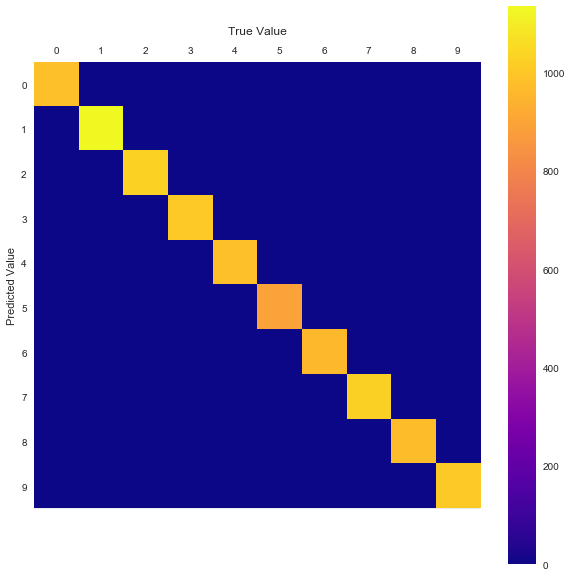

In [74]:
plot_matrix(target_matrix, palette = 'plasma')

C:\Users\caleb\AppData\Local\conda\conda\envs\tensorflow-env\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


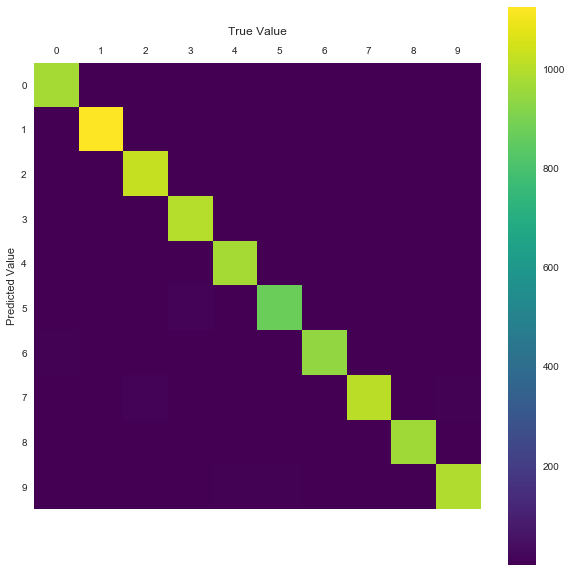

In [75]:
plot_matrix(confusion_matrix)

C:\Users\caleb\AppData\Local\conda\conda\envs\tensorflow-env\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


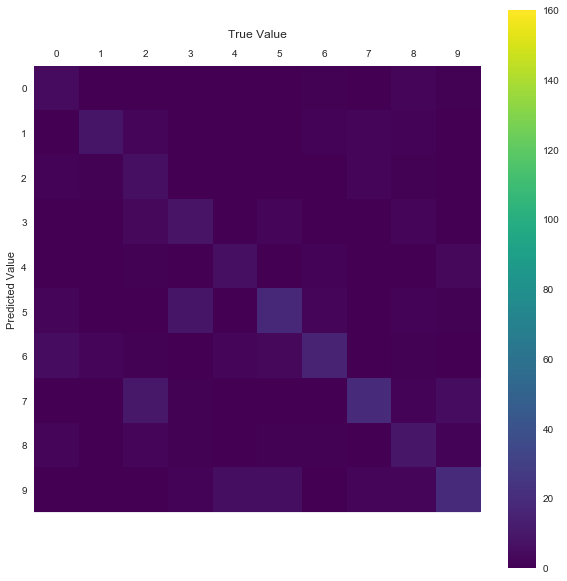

In [11]:
plot_matrix(accuracy_matrix)
plt.clim(0, 160)

In [12]:
preds = np.argmax(prediction, axis=1)
targs = np.argmax(test_labels, axis=1)
hits = preds == targs

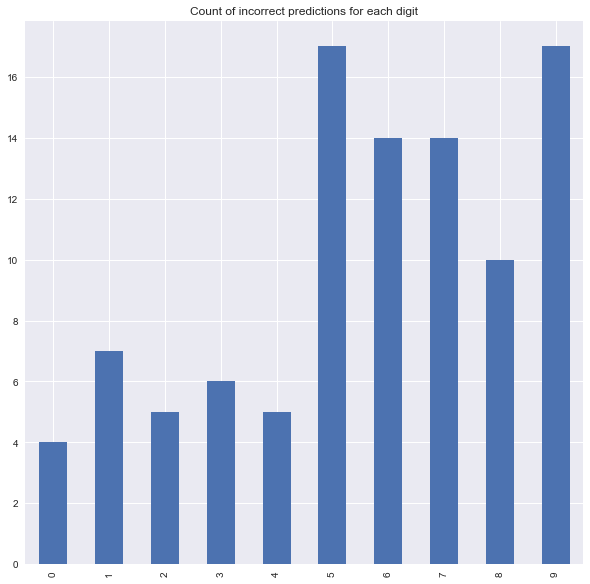

In [15]:
miss_freqs = pd.Series(targs[hits == False])\
               .value_counts()\
               .sort_index()
miss_freqs.plot(kind = 'bar',
                title = 'Count of incorrect predictions for each digit')

C:\Users\caleb\AppData\Local\conda\conda\envs\tensorflow-env\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


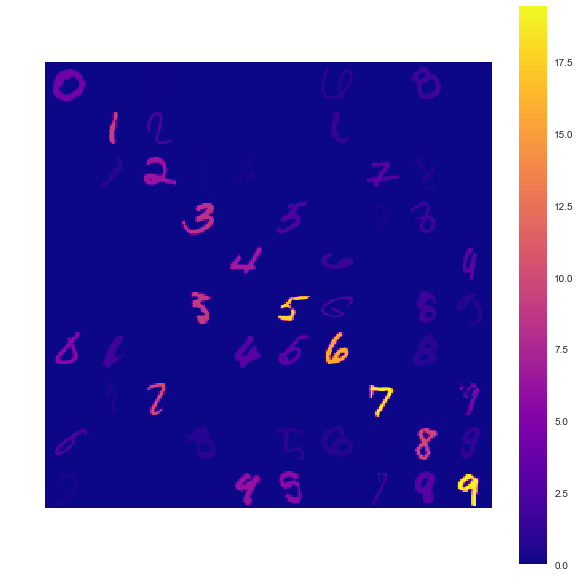

In [80]:
def mask_by_classification(pred, targ):
    '''Returns a digit that the model misclassified as pred
       when the true value was targ'''
    mask = np.logical_and(preds == pred, targs == targ)
    return mask

def entropy(x):
    return -x * np.log(x)

entropies = np.sum(entropy(prediction), axis=1)

res = []
for i, j in it.product(range(10), range(10)):
    mask = mask_by_classification(i, j)
    pred = prediction[mask]
    test = test_images[mask]
    
    if not np.any(mask):
        res.append(np.zeros(shape=(28,28)))
    else:
        index = np.argmin(entropies[mask])
        res.append(test[index].reshape(28,28) * accuracy_matrix[i, j])

rows = []
for r in range(0, 100, 10):
    row = res[r:r+10]
    rows.append(np.concatenate(row, axis=1))
image = np.concatenate(rows, axis=0)

plot_matrix(image, palette = 'plasma', ticks=False)

C:\Users\caleb\AppData\Local\conda\conda\envs\tensorflow-env\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


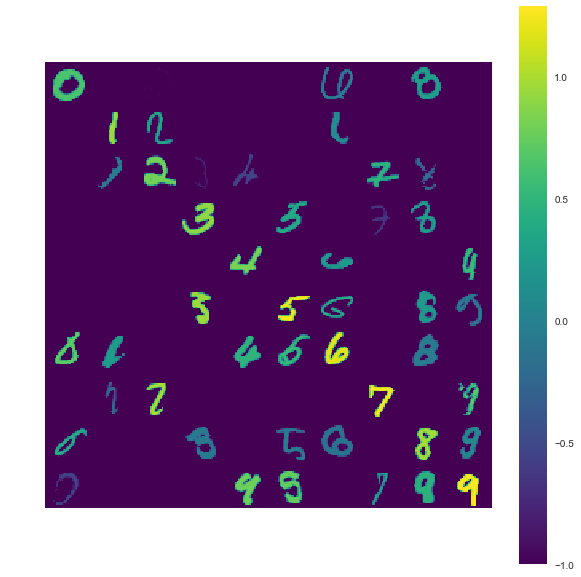

In [17]:
log_image = image
log_image[log_image < 0.1] = 0.1
log_image = np.log10(log_image)
plot_matrix(log_image, ticks=False)